In [2]:
completePath = "data/energydata_complete.csv"
trainingPath = "data/training.csv"
testingPath = "data/testing.csv"

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv(completePath)

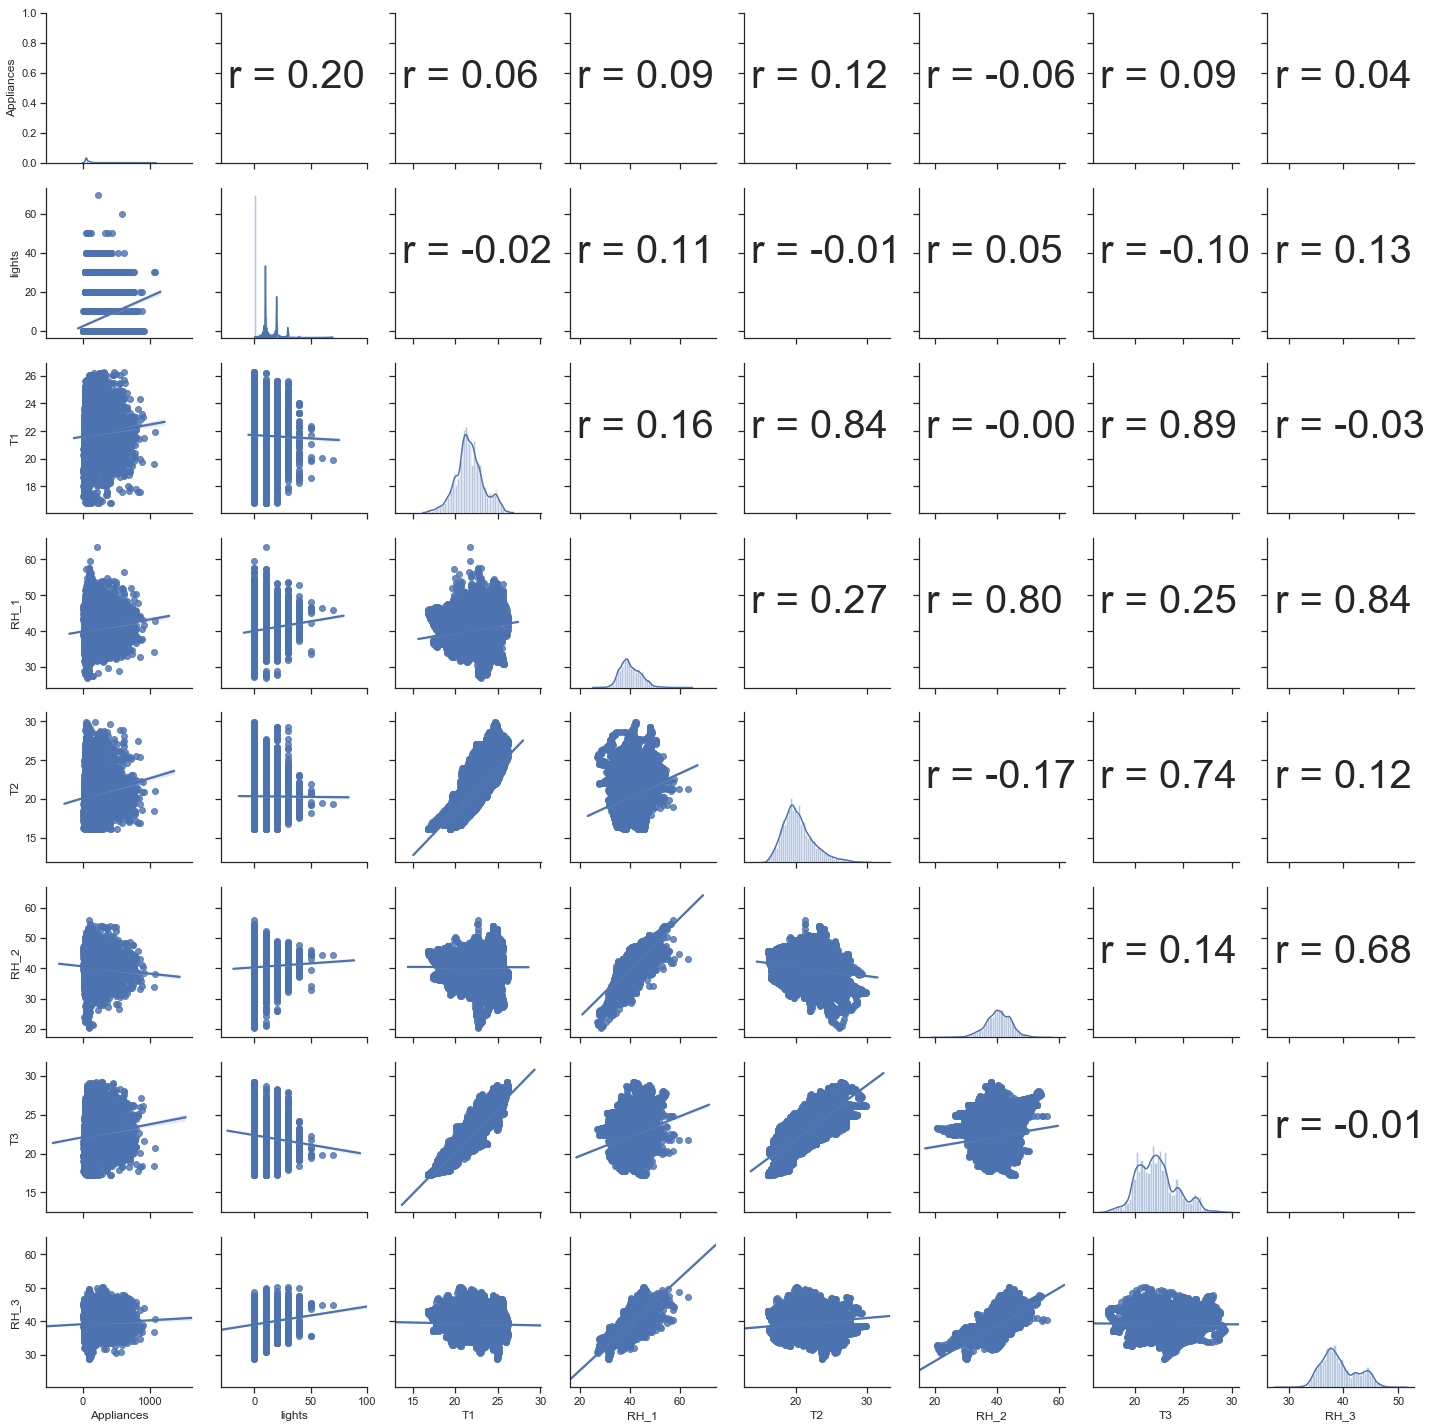

In [5]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),xy=(0.05, .5), xycoords=ax.transAxes,size=40)

sns.set(style="ticks", color_codes=True)
pairp = sns.PairGrid(df,vars=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3','RH_3'])
pairp.map_diag(sns.distplot),pairp.map_lower(sns.regplot),pairp.map_upper(corrfunc)
None

## Pairs plot reproduction

Here i have tried to recreate the exact plot from the paper with some custom code. I had to add in the numeric correlation values aswell as the scatter + line of best fit plots using seaborns "Pairgrid" function.

All the plots and correlation coefficients look the same as the paper

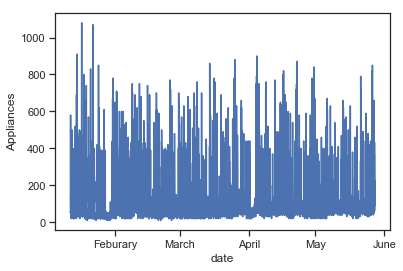

In [7]:
df['date'] = pd.to_datetime(df['date'])
dayMap = dict(zip([6]+list(range(0,6)),range(0,7))) #so the 1st day is sunday not monday
monthNames = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['week'],df['day'],df['hour'],df['month'] = df['date'].map(lambda x: x.isocalendar()[1]) ,df['date'].map(lambda x: dayMap[x.weekday()]) ,df['date'].map(lambda x: x.hour),df['date'].map(lambda x: x.month)
df = df.sort_values('date')
ticks = [pd.datetime(2016,e,1,0) for e in range (2,7)]
mLine = sns.lineplot(df['date'],df['Appliances'])
mLine.set_xticks(ticks),mLine.set(xticklabels=[monthNames[e.month-1] for e in ticks]) #-1 so that the tick represents the END of the month,mLine.set(xlim =(pd.datetime(2016,1,1,0), pd.datetime(2016,6,1,0)))
None

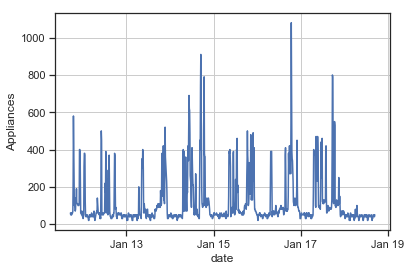

In [8]:
wLine = sns.lineplot(df['date'][1:1008],df['Appliances'][1:1008])
ticks = [pd.datetime(2016,1,13 + e,0) for e in range (0,8,2)]
wLine.set_xticks(ticks),wLine.set(xticklabels=["Jan " + str(e.day) for e in ticks]),wLine.grid(True)
None

## Appliance energy consumption lineplots

Here i had to take the appliance energy and plot it over time, this took me a while to figure out they where labeling the date ticks differently than the python default. In order to remedy this i had to make the ticks line up with the end of the month.

after this i did the 1 day plot and realised just setting the start-end range to the days specified in the paper would give me incorrect results, instead i had to use the exact array slice its woth noting that this may mean that the graph in the paper isnt quite matching up with its label.

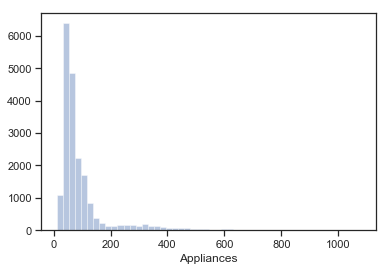

In [9]:
sns.distplot(df['Appliances'], kde=False)
None

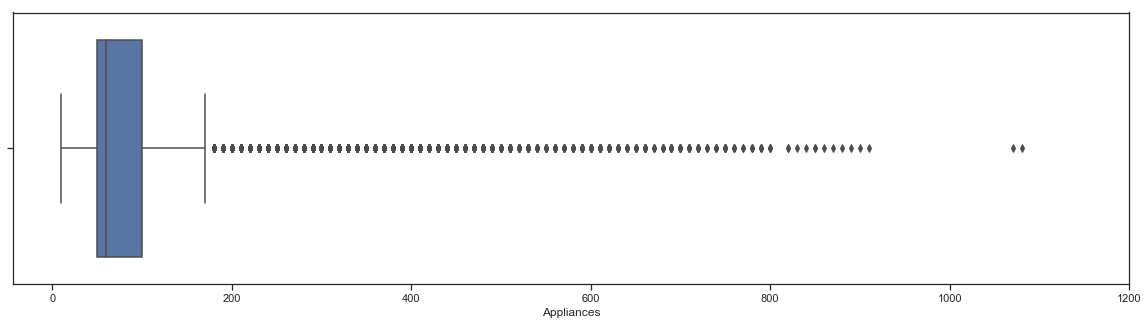

In [10]:
fig,ax = plt.subplots(figsize=(20,5)),sns.boxplot(df['Appliances']).set_xticks(range(0,1201,200))
None

## Distribution plots

Next i had to reproduce both the histogram and box plot for the distribution of the appliance energy consumption feild my results look the same as the paper and this one was straightfoward.

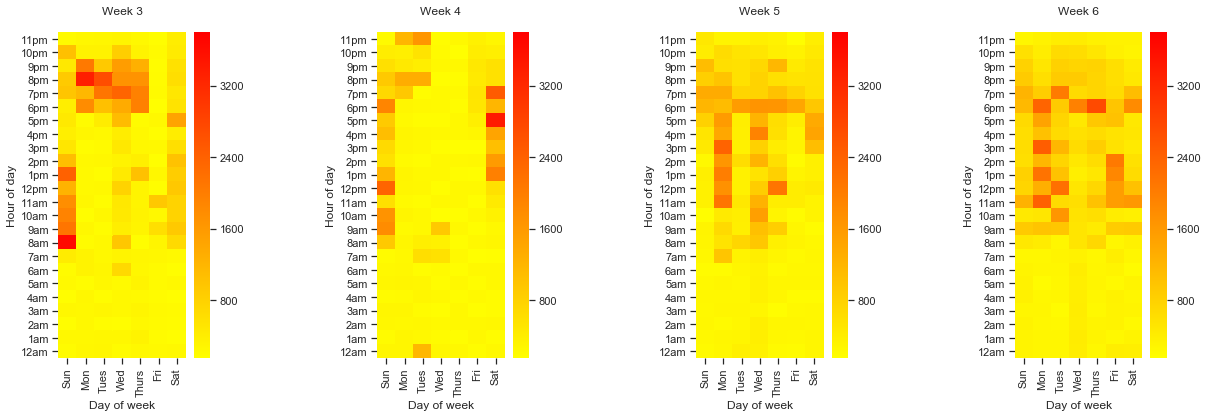

In [11]:
hourLables = (["12am"] + [str(e)+"am"  for e in range(1,12)] + ["12pm"] + [str(e)+"pm"  for e in range(1,12)])[::-1]
dayNames = ['Sun','Mon','Tues','Wed','Thurs','Fri','Sat']

weeks = range(3,7)
fig, axArr = plt.subplots(1,len(weeks),figsize=(20,6), gridspec_kw=dict(wspace=1))
for week,ax in zip(weeks,axArr):
    pivot = pd.pivot_table(df[df['week'] == week] [['day','hour', 'Appliances']], index=['day', 'hour'], aggfunc='sum')
    unstacked = pivot.unstack(level=0)
    ax = sns.heatmap(unstacked.sort_index(ascending=False), fmt="d", ax=ax,cmap='autumn_r',vmin=150, vmax=3800,xticklabels=dayNames,yticklabels=hourLables)
    ax.axes.set_title(f"Week {week}\n")
    ax.set(xlabel='Day of week', ylabel='Hour of day');
plt.show()

## Hourly usage heatmap

here i took the first 4 weeks (3-6) and i created a heatmap for each week, i had to dig around the R notebook to reproduce this properly, the hardwired heat map max/min are taken directly from it aswell as the weeks.
<br><br>
Its worth noting that the week 6's heatmap seems visually different as it has an "L" shape at Fri/Sat at around midday where was the paper does not, i took some time to ensure i was sampling correctly and came to the conclusion that it was due to differing gradients as i have the same timestamps and week selected in that heatmap.

Total number of features: 28

Optimal features: 27


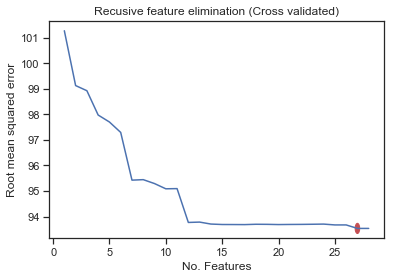

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from matplotlib.patches import Circle

import math

dateToInt = dict(zip(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], range(0,7)))

def makeNumeric(df):
    df['WeekStatus'] = df['WeekStatus'].map(lambda x : 0 if x is "Weekend" else 1)
    df['Day_of_week'] = df['Day_of_week'].map(lambda x: dateToInt[x])
    return df

df_train, df_test = pd.read_csv(trainingPath).drop(['rv1','rv2'],axis=1),pd.read_csv(testingPath).drop(['rv1','rv2'],axis=1)
#remove random variables as our models shouldn't use them
df_train, df_test = makeNumeric(df_train), makeNumeric(df_test)
df_train_test = pd.concat([df_train , df_test])

predictors = df_train_test._get_numeric_data().drop(['Appliances'], axis=1)
print(f"Total number of features: {predictors.columns.values.size}\n")


split = [(range(0,len(df_train)),range(len(df_train),len(df_train) + len(df_test)))]

def RMSE(estimator, X, y):
    return(math.sqrt(np.mean( (y - estimator.predict(X)) ** 2)))
        
def residPlot(predictors,y,model):
    y_hat = model.predict(predictors)
    residuals = y - y_hat
    sns.scatterplot(y,residuals)
    plt.ylabel("Residuals")
    plt.xlabel("Appliances Energy Consumption")
    plt.title = 'Residual Plot'
    plt.axhline(color='r')
    
def trainReduced(pred,y): 
    return RFECV(LinearRegression(),step=1,scoring=RMSE,cv=split).fit(pred,y)

model =trainReduced(predictors,df_train_test['Appliances'])

sns.lineplot(range(1,len(model.grid_scores_) + 1),model.grid_scores_).set_title('Recusive feature elimination (Cross validated)')
plt.ylabel("Root mean squared error")
plt.xlabel("No. Features")
minError = np.argmin(model.grid_scores_) + 1;
print(f"Optimal features: {minError}")
plt.gcf().gca().add_artist(Circle((minError,model.grid_scores_[minError -1]),0.2,color='r')) ## add blip for min error
plt.show()
None

## Recursive feature elimination and cross validation

Following the paper i implemented feature elimination with "cross validation".I opted to use linear regression as my model due to the residuals and results better matching the paper.

The data was not initally ready for RFE, first i had remove the "random variables" (rv1 and rv2), I then had to convert the "weekday" and "day of week" columns to numeric vales. I achived this by making a MakeNumeric() function. 

After this i printed out the amount of features and realized i didnt have the same amount as the paper but after some playing around with the data i opted to leave out the random variables as in the R note book the researchers did the same and my resuts where closer with them in.


After doing this i utilized [sklearns](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) RFECV fucntion, i specified i wanted my own custom Root mean squared error function aswell as telling it to use the provided train/test split the rearchers had used, i achived this by combining the 2 dataframes then specifying what indexs belonged to what tuple. this resulted in only 1 cross validation but i felt this was aproprate as splitting into more bags would have caused my results to vary.

Its worth noting here that my results didnt exactly match the paper but i belive it was due to me not having the same amount of features.

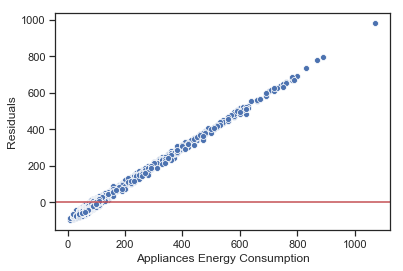

In [22]:
residPlot(df_test.drop(['Appliances'],axis=1)._get_numeric_data(),df_test['Appliances'],model)
None

## Residual plot

Once i had my reduced features i used my model to produce the residuals. I plotted them vs the appliance energy consumption, here my plot matches the paper quite well even down to the outlier in the top right however the points seem to be more tightly bound to the line.

its worth noting that their is no "Curve" in the residual plot leading us to belive that linear regression is a good model for this data.